# Three Layer Router - Reduced Measurements

In [1]:
import sys
sys.path.append('..') # Search for custom module in the top level. 

# Import my custom modules.
from allens_quantum_package.functions import * 
from allens_quantum_package.operators import *

from qiskit import *
from qiskit.quantum_info import state_fidelity
from qiskit_ibm_runtime import QiskitRuntimeService

import scipy
import numpy
from numpy import set_printoptions, radians, ndarray, radians, array, sqrt

import itertools

In [2]:
# Set the floating point diplay precision to 3 decimal places, sufficient for our purposes.
set_printoptions(precision=3)

# Initialise the Qiskit runtime service. 
service = QiskitRuntimeService()

In [2]:
states = [
    (radians(-88), radians(79)),
    (radians(32), radians(-167)),
    (radians(140), radians(125))
]

In [3]:
def build_circuit(theta, phi) -> QuantumCircuit:
    circ = QuantumCircuit(15, 8)

    # Route on first layer
    circ.h(7)
    circ.u(theta, phi, 0, 4)
    circ.cswap(7, 4, 10)

    # Route on second layer, top
    circ.h(3)
    circ.cswap(3, 2, 4)

    # Route on second layer, bottom
    circ.h(11)
    circ.cswap(11, 10, 12)

    # Route on third layer, first
    circ.h(0)
    circ.cswap(0, 1, 2)

    # Route on third layer, second
    circ.h(6)
    circ.cswap(6, 4, 5)

    # Route on third layer, third
    circ.h(8)
    circ.cswap(8, 9, 10)

    # Route on third layer, fourth
    circ.h(14)
    circ.cswap(14, 12, 13)

    return circ

In [5]:
build_circuit(*states[0]).draw()

┌───┐                  
 q_0: ─────────┤ H ├────────────────■─
               └───┘                │ 
 q_1: ──────────────────────────────X─
                                    │ 
 q_2: ───────────────────────────X──X─
               ┌───┐             │    
 q_3: ─────────┤ H ├─────────────■────
      ┌────────┴───┴────────┐    │    
 q_4: ┤ U(-1.5359,1.3788,0) ├─X──X──X─
      └─────────────────────┘ │     │ 
 q_5: ────────────────────────┼─────X─
               ┌───┐          │     │ 
 q_6: ─────────┤ H ├──────────┼─────■─
               ├───┤          │       
 q_7: ─────────┤ H ├──────────■───────
               ├───┤          │       
 q_8: ─────────┤ H ├──────────┼─────■─
               └───┘          │     │ 
 q_9: ────────────────────────┼─────X─
                              │     │ 
q_10: ────────────────────────X──X──X─
               ┌───┐             │    
q_11: ─────────┤ H ├─────────────■────
               └───┘             │    
q_12: ───────────────────────────X──X─
                                    │ 
q_13: ──────────────────────────────X─
               ┌───┐                │ 
q_14: ─────────┤ H ├────────────────■─
               └───┘                  
 c: 8/════════════════════════════════

In [4]:
def add_basis_meas(circuit, qubit, basis='z') -> QuantumCircuit:
    circ = circuit.copy()
    circ.barrier()

    if basis == 'x':
        circ.h(qubit)
    elif basis == 'y':
        circ.sdg(qubit)
        circ.h(qubit)

    circ.barrier()

    circ.measure([0, 3, 6, 7, 8, 11, 14] + [qubit], [0, 1, 2, 3, 4, 5, 6, 7])

    return circ


# Create named tuple object, for easy indexing, e.g. ".x", instead of "[0]"
TomographySet = namedtuple('TomographySet', ['x', 'y', 'z'])


def get_tomography_circuits(circuit, qubit) -> list[QuantumCircuit]:
    return [
        add_basis_meas(circuit, qubit, 'x'),
        add_basis_meas(circuit, qubit, 'y'),
        add_basis_meas(circuit, qubit, 'z')
    ]

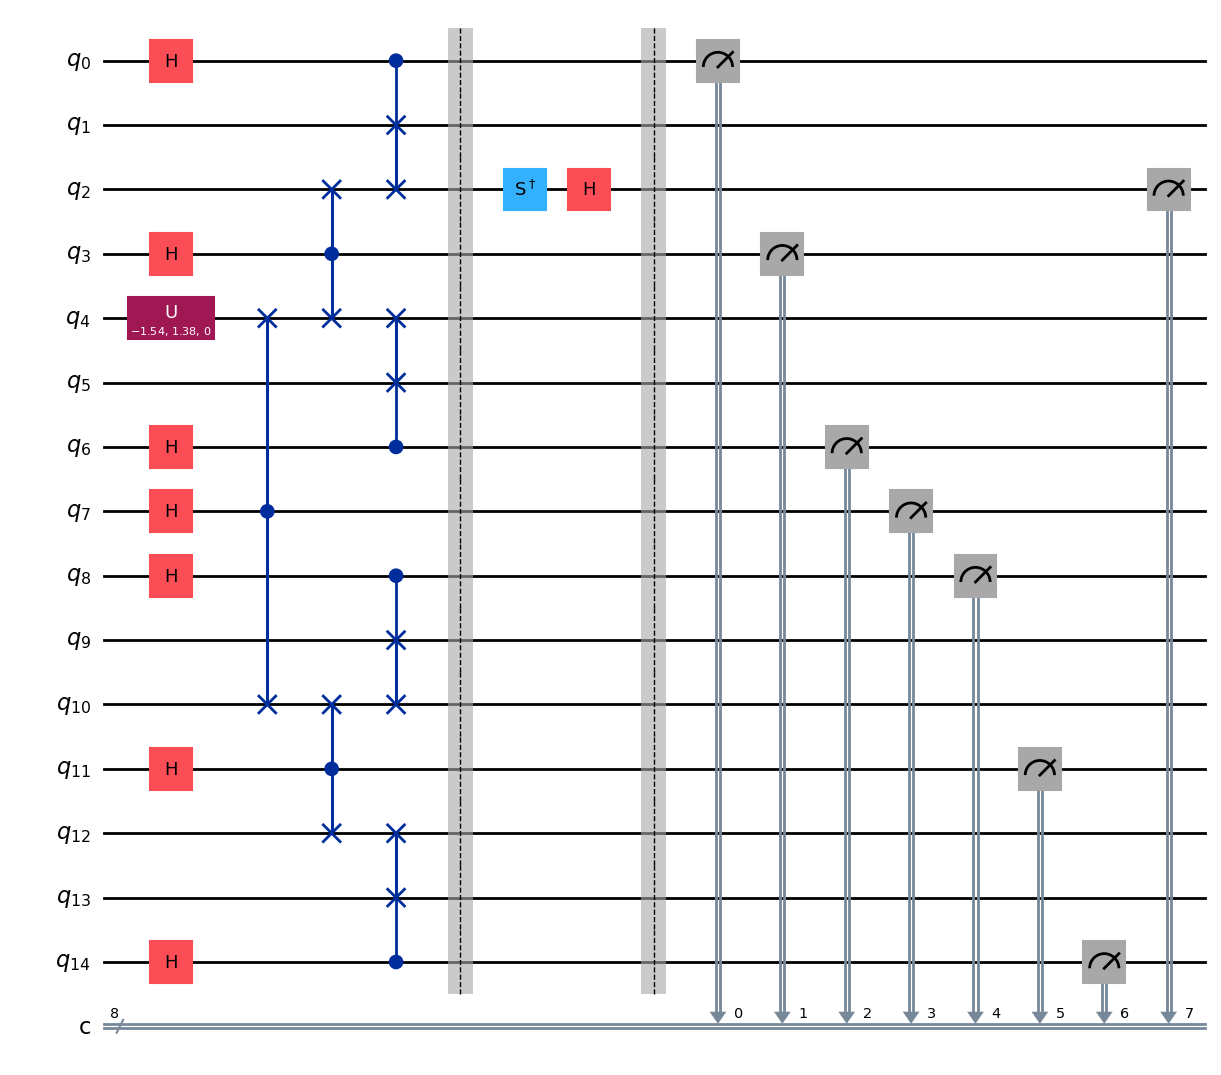

In [6]:
get_tomography_circuits(build_circuit(*states[0]), 2)[1].draw('mpl')

In [8]:
def generate_tomography_sets(theta, phi) -> list[list[QuantumCircuit]]:
    return [ 
        *get_tomography_circuits(
            build_circuit(theta, phi), 1
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 2
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 4
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 5
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 9
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 10
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 12
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 13
        )
    ]

In [9]:
ibm_brisbane = service.get_backend('ibm_brisbane')

In [10]:
circuits_to_send = list(itertools.chain.from_iterable([
        circuit for circuit in [
            itertools.chain.from_iterable(generate_tomography_sets(theta, phi) for theta, phi in states)
        ]
    ]
))

circuits_to_send = [transpile(circuit, ibm_brisbane) for circuit in circuits_to_send]

In [11]:
def get_all_physical_qubits(circuit_list: list[QuantumCircuit]) -> set[int]:
    all_indices = set()
    for circ in circuit_list:    
        measurement_indices = [instr[1][0]._index for instr in circ.data if instr[0].name == 'measure']
        all_indices = all_indices.union(measurement_indices)
    return all_indices


def get_mitigation_circuits(circuit_list: list[QuantumCircuit]) -> list[QuantumCircuit]:

    physical_qubits = get_all_physical_qubits(circuit_list)

    num_qubits = len(physical_qubits)
    all_0 = QuantumCircuit(127, num_qubits)
    all_0.measure(physical_qubits, range(num_qubits))

    all_1 = QuantumCircuit(127, num_qubits)
    all_1.x(physical_qubits)
    all_1.measure(physical_qubits, range(num_qubits))

    return [all_0, all_1]

In [12]:
circuits_to_send = get_mitigation_circuits(circuits_to_send) + circuits_to_send

In [13]:
hardware_job = ibm_brisbane.run(circuits=circuits_to_send)

In [14]:
print(f"Hardware job ID: {hardware_job.job_id()}")

Hardware job ID: cw6fa9hjzdhg008e2tjg


---

In [15]:
results = hardware_job.result().get_counts()

In [16]:
def get_combined_xyz_counts_for_circuit(counts_list: list) -> tuple[dict]:

    output_qubit_1 = []
    for counts in counts_list[0:3]:
        counts_dict = {}

        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[6:8] == '11' and bit_string[4] == '0' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[6:8] == '11' and bit_string[4] == '0' and bit_string[0] == '1')

        output_qubit_1.append(counts_dict)

    output_qubit_2 = []
    for counts in counts_list[3:6]:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[6:8] == '10' and bit_string[4] == '0' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[6:8] == '10' and bit_string[4] == '0' and bit_string[0] == '1')

        output_qubit_2.append(counts_dict)

    output_qubit_4 = []
    for counts in counts_list[6:9]:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[4:7] == '000' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[4:7] == '000' and bit_string[0] == '1')    
    
        output_qubit_4.append(counts_dict)
    
    output_qubit_5 = []
    for counts in counts_list[9:12]:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[4:7] == '010' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[4:7] == '010' and bit_string[0] == '1')    
    
        output_qubit_5.append(counts_dict)

    output_qubit_9 = []
    for counts in counts_list[12:15]:
        counts_dict = {}

        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[2:5] == '011' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[2:5] == '011' and bit_string[0] == '1')

        output_qubit_9.append(counts_dict)

    output_qubit_10 = []
    for counts in counts_list[15:18]:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[2:5] == '001' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[2:5] == '001' and bit_string[0] == '1')

        output_qubit_10.append(counts_dict)

    output_qubit_12 = []
    for counts in counts_list[18:21]:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[1:3] == '01' and bit_string[4] == '1' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[1:3] == '01' and bit_string[4] == '1' and bit_string[0] == '1')    

        output_qubit_12.append(counts_dict)

    output_qubit_13 = []
    for counts in counts_list[21:24]:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[1:3] == '11' and bit_string[4] == '1' and bit_string[0] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[1:3] == '11' and bit_string[4] == '1' and bit_string[0] == '1')    

        output_qubit_13.append(counts_dict)

    output = (add_dicts(*dicts) for dicts in zip(output_qubit_1, 
                                                 output_qubit_2, 
                                                 output_qubit_4, 
                                                 output_qubit_5, 
                                                 output_qubit_9,
                                                 output_qubit_10, 
                                                 output_qubit_12, 
                                                 output_qubit_13))   
    
    return tuple(output)


def print_unmitigated_fidelities_combined(counts, theta, phi):

    qubit = density_op_from_counts_dict(*get_combined_xyz_counts_for_circuit(counts))

    print(get_combined_xyz_counts_for_circuit(counts))
    print(qubit)

    psi = gen_qubit(theta, phi)

    fidelity_q = state_fidelity(qubit, psi)

    print(f'State fidelity from combined counts: {fidelity_q}\n')

In [17]:
print_unmitigated_fidelities_combined(results[2:26], *states[0])
print_unmitigated_fidelities_combined(results[26:50], *states[1])
print_unmitigated_fidelities_combined(results[50:76], *states[2])

({'0': 1958, '1': 2251}, {'0': 2254, '1': 2325}, {'0': 2295, '1': 1881})
[[ 0.55 +0.j    -0.035+0.008j]
 [-0.035-0.008j  0.45 +0.j   ]]
State fidelity from combined counts: 0.5159729621338129

({'0': 2020, '1': 1999}, {'0': 1859, '1': 2066}, {'0': 2028, '1': 1634})
[[0.554+0.j    0.003+0.026j]
 [0.003-0.026j 0.446+0.j   ]]
State fidelity from combined counts: 0.5474157878843062

({'0': 1755, '1': 1667}, {'0': 2054, '1': 1974}, {'0': 2456, '1': 1633})
[[0.601+0.j   0.013-0.01j]
 [0.013+0.01j 0.399+0.j  ]]
State fidelity from combined counts: 0.42339669089426824



In [18]:
# Gets the map from a physical qubit to a classical bit for the mitigation calibration matrices
def get_qubit_to_clbit_mappings_for_mitigation(circuit: QuantumCircuit) -> dict[int, int]:
    return dict(
        ((instr[1][0]._index, instr[2][0]._index) for instr in circuit.data if instr[0].name == 'measure')
    )

# Gets the map from physical qubit to mitigation matrix
def get_assignment_matrices(mappings: dict, counts_0: dict, counts_1: dict) -> dict[int, ndarray]:

    output = {}

    for physical_qubit, classical_bit in mappings.items():
        
        # Determine zero state for assignment matrix
        result_0 = sum([count for bit_string, count in counts_0.items() if bit_string[classical_bit] == '0'])
        result_1 = sum([count for bit_string, count in counts_0.items() if bit_string[classical_bit] == '1'])
        
        # Calculate zero ket
        zero_ket = array([[result_0], 
                          [result_1]]) / (result_0 + result_1)
        
        # Determine one state for assignment matrix
        result_0 = sum([count for bit_string, count in counts_1.items() if bit_string[classical_bit] == '0'])
        result_1 = sum([count for bit_string, count in counts_1.items() if bit_string[classical_bit] == '1'])
        
        # Calculate zero ket
        one_ket = array([[result_0], 
                         [result_1]]) / (result_0 + result_1)
        
        assignment_matrix = numpy.concatenate([zero_ket, one_ket], axis=1)

        output[physical_qubit] = assignment_matrix
    
    return output

# Get the list of physical qubits in the same order as the classical bits 
def get_qubits_in_clbit_order(circuit: QuantumCircuit) -> list[int]:
    
    cl_bit_to_qbit_map = dict((instr[2][0]._index, instr[1][0]._index) for instr in circuit.data if instr[0].name == 'measure')

    return [*cl_bit_to_qbit_map.values()]
    

# Get the tensor of all mitigation matrices in the correct order for each circuit
def get_mitigation_matrix(circuit: QuantumCircuit, assignment_mappings: dict) -> ndarray:
    ordered_physical_qubits = get_qubits_in_clbit_order(circuit)

    ordered_physical_qubits.reverse()

    assignment_matrices = [assignment_mappings[qubit] for qubit in ordered_physical_qubits]

    return tens(*(scipy.linalg.inv(mat) for mat in assignment_matrices))


def get_bit_strings(count: int) -> list[str]:
    return [''.join(bits) for bits in itertools.product(['0', '1'], repeat=count)]


def get_corrected_counts(circuit: QuantumCircuit, counts_for_mitigation: dict, assignment_mappings: dict, num_qubits: int) -> dict[str, int]:
    bit_strings = get_bit_strings(num_qubits)

    counts_list = []
    for bit_string in bit_strings:
        counts_list.append(counts_for_mitigation[bit_string] if bit_string in counts_for_mitigation else 0)
    
    # Get vector of counts
    counts_vector = numpy.concatenate(
        array([[count for count in counts_list]]),
        axis=0
    )

    mitigation_matrix = get_mitigation_matrix(circuit, assignment_mappings)
    
    # Multiply by mitigation matirx
    corrected_vector = mitigation_matrix @ counts_vector
    corrected_vector = corrected_vector.astype(int)
    
    output = {}
    for idx, bit_string in zip(range(2**num_qubits), bit_strings):
        output[bit_string] = int(corrected_vector[idx])
    
    return output

In [19]:
# Get list of qubit to clbit mappings for the mitigation circuits.
mitigation_mappings = get_qubit_to_clbit_mappings_for_mitigation(circuits_to_send[0])

# Calculate assignment matrices for each qubit. 
assignment_matrices = get_assignment_matrices(mitigation_mappings, results[0], results[1])

In [20]:
def print_mitigated_fidelities_combined(circuits, counts, assignment_matrices, num_qubits, theta, phi):

    mitigated_counts = []

    for circuit, count in zip(circuits, counts):
        mitigated_counts.append(get_corrected_counts(circuit, count, assignment_matrices, num_qubits))

    qubit = density_op_from_counts_dict(*get_combined_xyz_counts_for_circuit(mitigated_counts))
    
    print(get_combined_xyz_counts_for_circuit(mitigated_counts))
    print(qubit)

    psi = gen_qubit(theta, phi)

    fidelity_q = state_fidelity(qubit, psi)

    print(f'Mitigated state fidelity from combined counts: {fidelity_q}\n')

In [21]:
print_mitigated_fidelities_combined(circuits_to_send[2:26], results[2:26], assignment_matrices, 8, *states[0])
print_mitigated_fidelities_combined(circuits_to_send[26:50], results[26:50], assignment_matrices, 8, *states[1])
print_mitigated_fidelities_combined(circuits_to_send[50:74], results[50:74], assignment_matrices, 8, *states[2])

({'0': 1878, '1': 2206}, {'0': 2221, '1': 2254}, {'0': 2195, '1': 1869})
[[ 0.54+0.j    -0.04+0.004j]
 [-0.04-0.004j  0.46+0.j   ]]
Mitigated state fidelity from combined counts: 0.512674554683799

({'0': 1934, '1': 1962}, {'0': 1815, '1': 2022}, {'0': 1989, '1': 1624})
[[ 0.551+0.j    -0.004+0.027j]
 [-0.004-0.027j  0.449+0.j   ]]
Mitigated state fidelity from combined counts: 0.5479075448898785

({'0': 1651, '1': 1588}, {'0': 1984, '1': 1911}, {'0': 2411, '1': 1571})
[[0.605+0.j    0.01 -0.009j]
 [0.01 +0.009j 0.395+0.j   ]]
Mitigated state fidelity from combined counts: 0.42055037727912536

